In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Change path accordingly if data is saved in your Drive
zip_path1 = '/content/gdrive/MyDrive/CV_3/TrainIJCNN2013.zip'
zip_path2 = '/content/gdrive/MyDrive/CV_3/TestIJCNN2013.zip'
yaml_path = '/content/gdrive/MyDrive/CV_3/data.yaml'

Mounted at /content/gdrive


In [ ]:
import os
import zipfile
import shutil

# # Uncomment zip_path, if data is saved locally
# zip_path1 = '/content/TestIJCNN2013.zip'

zip_ref = zipfile.ZipFile(zip_path1, 'r')
zip_ref.extractall('/content')
zip_ref.close()

# # Uncomment zip_path, if data is saved locally
# local_zip2 = '/content/TrainIJCNN2013.zip'

zip_ref = zipfile.ZipFile(zip_path2, 'r')
zip_ref.extractall('/content')
zip_ref.close()

# # Comment the command below, if yaml file is saved locally
shutil.copy(yaml_path,'/content')

'/content/data.yaml'

In [ ]:
import numpy as np
import cv2

train_dir = 'TrainIJCNN2013'

train_files = os.listdir(train_dir)

file_max_dim = []
file_aspect_ratio = []
for file in train_files:
  path = os.path.join(train_dir, file)
  if (not os.path.isfile(path)) or file.endswith('.txt'):
    continue
  img_shape = (cv2.imread(path)).shape
  file_max_dim.append(max(img_shape))
  file_aspect_ratio.append(img_shape[1]/img_shape[0])


total_files = len(file_max_dim)
train_dim = round((sum(file_max_dim)/total_files))
train_aspect_ratio = sum(file_aspect_ratio)/total_files

print("The average (max) dimension in train (and validation) data is: %d" % train_dim)
print("The average aspect ratio in train (and validation) data is: %.2f" % train_aspect_ratio)

The average (max) dimension in train (and validation) data is: 1360
The average aspect ratio in train (and validation) data is: 1.70


Plot a train image to ensure successful operation:



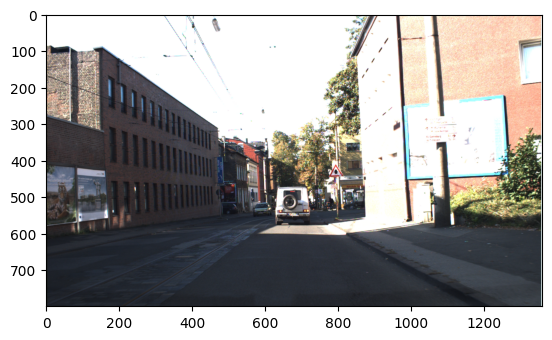


Plot a test image to ensure successful operation:



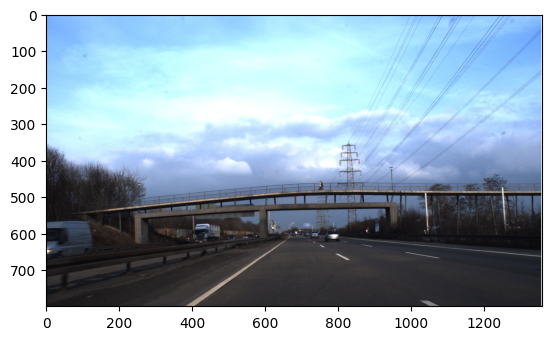

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = 'TrainIJCNN2013/00000.ppm'
img = mpimg.imread(img_path)
plt.imshow(img)

print("Plot a train image to ensure successful operation:")
print()
plt.show()

img_path = 'TestIJCNN2013Download/00000.ppm'
img = mpimg.imread(img_path)
plt.imshow(img)

print()
print("Plot a test image to ensure successful operation:")
print()
plt.show()

In [ ]:
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import csv

def convert_to_CSV_and_split(txt_file, image_dir):

    csv_file = os.path.join(image_dir,"_annotations.csv")

    with open(txt_file, 'r') as in_file:
        stripped = (line.strip() for line in in_file)
        lines = (line.split(";") for line in stripped if line)
        with open(csv_file, 'w') as out_file:
            writer = csv.writer(out_file)
            writer.writerow(('filename', 'xleft','ytop','xright','ybottom','class_id'))
            writer.writerows(lines)

    # Read CSV file
    df = pd.read_csv(csv_file)

    unique_filenames = df["filename"].unique()
    # Split the dataset: 90% for training, 10% for validation
    train_filenames, val_filenames = train_test_split(unique_filenames, test_size=0.1, random_state=1)

    train_df = df[df["filename"].isin(train_filenames)]
    val_df = df[df["filename"].isin(val_filenames)]

    # Save the new train and validation sets to CSV files
    train_csv = os.path.join(image_dir,"train_annotations.csv")
    val_csv = os.path.join(image_dir,"valid_annotations.csv")

    train_df.to_csv(train_csv, index=False)
    val_df.to_csv(val_csv, index=False)


def convert_to_yolo_format(csv_file, image_dir, output_dir):
    """
    Converts dataset annotations to YOLO format and saves them in the specified output directory.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Read CSV file
    df = pd.read_csv(csv_file)

    for filename in df["filename"].unique():
        annotations = df[df["filename"] == filename]
        img_path = os.path.join(image_dir, filename)
        img = Image.open(img_path)
        img_width, img_height = img.size

        # Prepare YOLO annotations
        yolo_annotations = []
        for _, row in annotations.iterrows():
            xleft, ytop, xright, ybottom, class_id = row[["xleft", "ytop", "xright", "ybottom", "class_id"]]
            x_center = ((xleft + xright) / 2) / img_width
            y_center = ((ytop + ybottom) / 2) / img_height
            width = (xright - xleft) / img_width
            height = (ybottom - ytop) / img_height
            yolo_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

        # Save YOLO annotations
        output_file = os.path.join(output_dir, os.path.splitext(filename)[0] + ".txt")

        with open(output_file, "w") as f:
            f.write("\n".join(yolo_annotations))


new_path = "TrainIJCNN2013/train"
os.makedirs(new_path, exist_ok=True)
new_path = "TrainIJCNN2013/valid"
os.makedirs(new_path, exist_ok=True)
convert_to_CSV_and_split("TrainIJCNN2013/gt.txt", "TrainIJCNN2013")

# Convert datasets to YOLO format
convert_to_yolo_format("TrainIJCNN2013/train_annotations.csv", "TrainIJCNN2013", "TrainIJCNN2013/train/train_labels")
convert_to_yolo_format("TrainIJCNN2013/valid_annotations.csv", "TrainIJCNN2013", "TrainIJCNN2013/valid/valid_labels")


In [ ]:
# Class name to integer mapping
CLASS_NAME_TO_ID = {}
for i in range(43):
  CLASS_NAME_TO_ID[str(i)] = i

def fix_yolo_labels(label_dir):
    """
    Convert class names to numeric IDs in YOLO label files.
    Args:
    - label_dir: Directory containing YOLO label files.
    """
    for label_file in os.listdir(label_dir):
        if label_file.endswith(".txt"):
            label_path = os.path.join(label_dir, label_file)
            fixed_labels = []

            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    class_name = parts[0]
                    bbox = parts[1:]

                    # Convert class name to numeric ID
                    if class_name in CLASS_NAME_TO_ID:
                        class_id = CLASS_NAME_TO_ID[class_name]
                        fixed_labels.append(f"{class_id} {' '.join(bbox)}")
                    else:
                        print(f"Skipping unknown class '{class_name}' in {label_file}")

            # Overwrite the label file with fixed labels
            with open(label_path, "w") as f:
                f.write("\n".join(fixed_labels))

# Fix labels for train, val, and test sets
fix_yolo_labels("TrainIJCNN2013/train/train_labels")
fix_yolo_labels("TrainIJCNN2013/valid/valid_labels")


In [ ]:
def organize_images(image_dir, label_dir, destination_dir):
    """
    Move all images to the correct 'images/' subdirectory.
    Args:
    - image_dir: Directory containing the images.
    - destination_dir: Target 'images/' directory.
    """
    os.makedirs(destination_dir, exist_ok=True)

    for label_file in os.listdir(label_dir):
        base_filename = os.path.splitext(label_file)[0]
        source_path = os.path.join(image_dir, base_filename+".ppm")
        img = Image.open(source_path)
        destination_path = os.path.join(destination_dir, base_filename+".jpg")
        img.save(destination_path)
        os.remove(source_path)

# Organize images into 'images/' subfolders
organize_images("TrainIJCNN2013", "TrainIJCNN2013/train/train_labels", "TrainIJCNN2013/train/images")
organize_images("TrainIJCNN2013", "TrainIJCNN2013/valid/valid_labels", "TrainIJCNN2013/valid/images")

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 911.6/911.6 kB 55.8 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

# Load YOLOv3 model
model = YOLO("yolov3.yaml")  # Specify the YOLOv3 architecture

# Train the model
model.train(data="/content/data.yaml", epochs=10, imgsz=400, batch=1, device=0)


Ultralytics 8.3.65 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov3.yaml, data=/content/data.yaml, epochs=10, time=None, patience=100, batch=1, imgsz=400, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, li

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 22.17 GiB of which 16.88 MiB is free. Process 38585 has 22.14 GiB memory in use. Of the allocated memory 21.79 GiB is allocated by PyTorch, and 92.09 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Evaluate the model
metrics = model.val()
print(metrics)

# Save the model
model.export(format="torchscript")  # Save trained weights

In [ ]:
def visualize_yolo_detections(image_path, model, confidence_threshold=0.5):
    """
    Visualize YOLO predictions on an image.

    Args:
    - image_path: Path to the input image.
    - model: YOLO model object.
    - confidence_threshold: Minimum confidence for displaying detections.
    """
    # Perform inference
    results = model(image_path)  # Run YOLO on the input image

    # Convert image for visualization
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Process detections
    detections = results[0].boxes  # Access the boxes property
    for det in detections:
        # Extract bounding box, confidence, and class
        box = det.xyxy.cpu().numpy()[0]  # xyxy format
        conf = det.conf.cpu().numpy()[0]  # Confidence score
        cls = int(det.cls.cpu().numpy()[0])  # Class index

        if conf < confidence_threshold:
            continue

        # Draw bounding box
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Add label
        label = f"{model.names[cls]} {conf:.2f}"
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Display the image with matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.title("YOLO Detections")
    plt.show()

In [ ]:
# Test images directory
test_images_dir = "/content/TestIJCNN2013Download"

# List all test images
test_images = os.listdir(test_images_dir)

# Load the trained YOLO model
model = YOLO("/content/runs/detect/train5/weights/best.pt")  # Load the trained YOLOv3 model

# Visualize predictions for a few images
for i in range(10):  # Visualize first 10 images
    image_path = os.path.join(test_images_dir, test_images[i])
    print(f"Visualizing predictions for: {test_images[i]}")
    visualize_yolo_detections(image_path, model, confidence_threshold=0.5)
